# Image Dataset Distribution Analysis
This notebook analyzes the distribution of images across different classes and splits (train/validation) in the datasets.

## Setup Environment and Imports
Import required libraries for data processing and visualization.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple

## Create Dataset Scanner Class
Implement a class to scan through dataset directories and collect image statistics.

In [13]:
class DatasetScanner:
    def __init__(self, root_dir: str):
        self.root_dir = Path(root_dir)
        self.image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.tif', '*.tiff', 
                               '*.JPG', '*.JPEG', '*.PNG', '*.TIF', '*.TIFF', '*.webp']
    
    def scan_split(self, split_path: Path) -> Dict[str, int]:
        class_counts = {}
        for class_dir in split_path.iterdir():
            if class_dir.is_dir():
                images = [img for ext in self.image_extensions for img in class_dir.rglob(ext)]
                n_images = len(images)
                class_counts[class_dir.name] = n_images
        return class_counts
    
    def scan_dataset(self) -> Dict[str, Dict[str, Dict[str, int]]]:
        dataset_info = {}
        
        for dataset_dir in self.root_dir.iterdir():
            if dataset_dir.is_dir():
                dataset_name = dataset_dir.name
                dataset_info[dataset_name] = {}
                
                # Automatically detect split folders
                split_folders = [d for d in dataset_dir.iterdir() if d.is_dir()]
                for split_dir in split_folders:
                    split_name = split_dir.name
                    dataset_info[dataset_name][split_name] = self.scan_split(split_dir)
        
        return dataset_info

## Load and Process Datasets
Scan through all datasets and organize the data into a structured format.

In [14]:
# Initialize scanner and process datasets
scanner = DatasetScanner('../datasets/final')
dataset_stats = scanner.scan_dataset()

# Convert to DataFrame format
rows = []
for dataset_name, splits in dataset_stats.items():
    for split_name, class_counts in splits.items():
        for class_name, count in class_counts.items():
            rows.append({
                'dataset': dataset_name,
                'split': split_name,
                'class': class_name,
                'count': count
            })

df = pd.DataFrame(rows)

## Generate Distribution Tables
Create summary tables showing class distributions for each dataset and split.

In [15]:
# Calculate percentage distributions
df['percentage'] = df.groupby(['dataset', 'split'])['count'].transform(
    lambda x: x / x.sum() * 100
)

# Create pivot tables for easy viewing
distribution_table = df.pivot_table(
    values=['count', 'percentage'],
    index=['dataset', 'class'],
    columns='split',
    fill_value=0
).round(2)

print("Dataset Distribution Summary:")
print(distribution_table)

Dataset Distribution Summary:
                                         count         percentage       
split                                     test   train       test  train
dataset                 class                                           
glomerulo               Crescent          20.0  1180.0      16.67  15.56
                        Hypercellularity  20.0  2048.0      16.67  27.01
                        Membranous        20.0  1608.0      16.67  21.21
                        Normal            20.0  1570.0      16.67  20.71
                        Podocytopathy     20.0   559.0      16.67   7.37
                        Sclerosis         20.0   617.0      16.67   8.14
ovarian-cancer-splitted Clear_Cell        19.0    81.0      20.43  20.00
                        Endometri         19.0    79.0      20.43  19.51
                        Mucinous          19.0    81.0      20.43  20.00
                        Non_Cancerous     18.0    82.0      19.35  20.25
                     

In [12]:
print("\nTotal counts per dataset and split:")
print(df.groupby(['dataset', 'split'])['count'].sum())



Total counts per dataset and split:
dataset                  split
glomerulo                test      116
                         train    7582
ovarian-cancer-splitted  test       93
                         train     405
skin-cancer-splitted     test      138
                         train    6906
Name: count, dtype: int64


In [11]:
total_records_per_dataset = df.groupby('dataset')['count'].sum()
print("Total number of records for each dataset:")
print(total_records_per_dataset)

Total number of records for each dataset:
dataset
glomerulo                  7698
ovarian-cancer-splitted     498
skin-cancer-splitted       7044
Name: count, dtype: int64


## Create Visualization Plots
Generate visualizations to compare class distributions across datasets and splits.

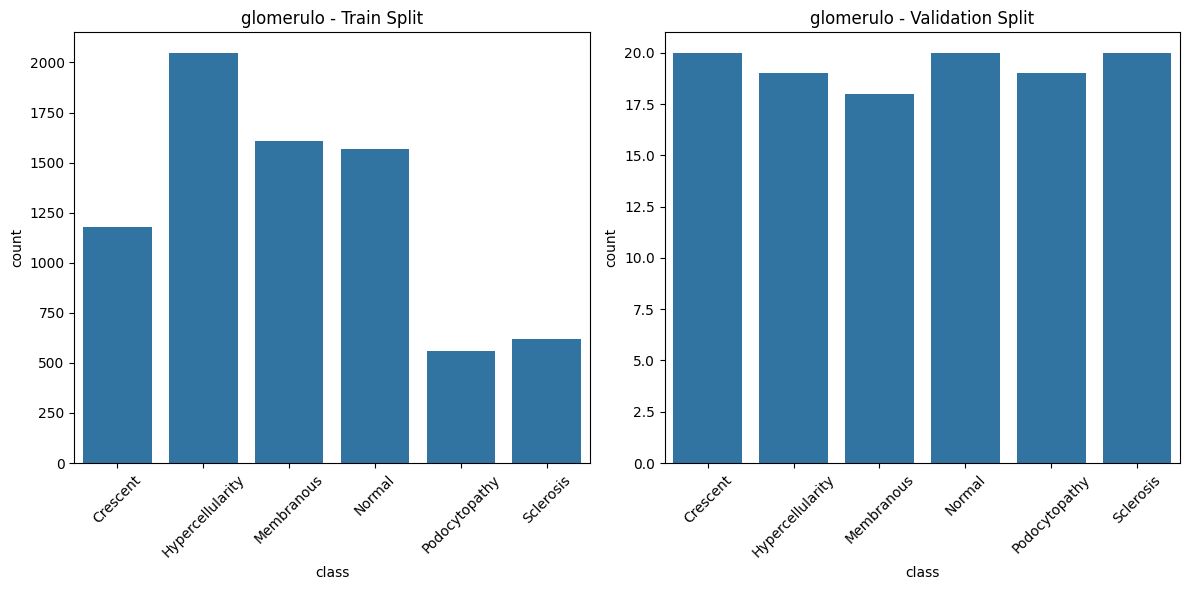

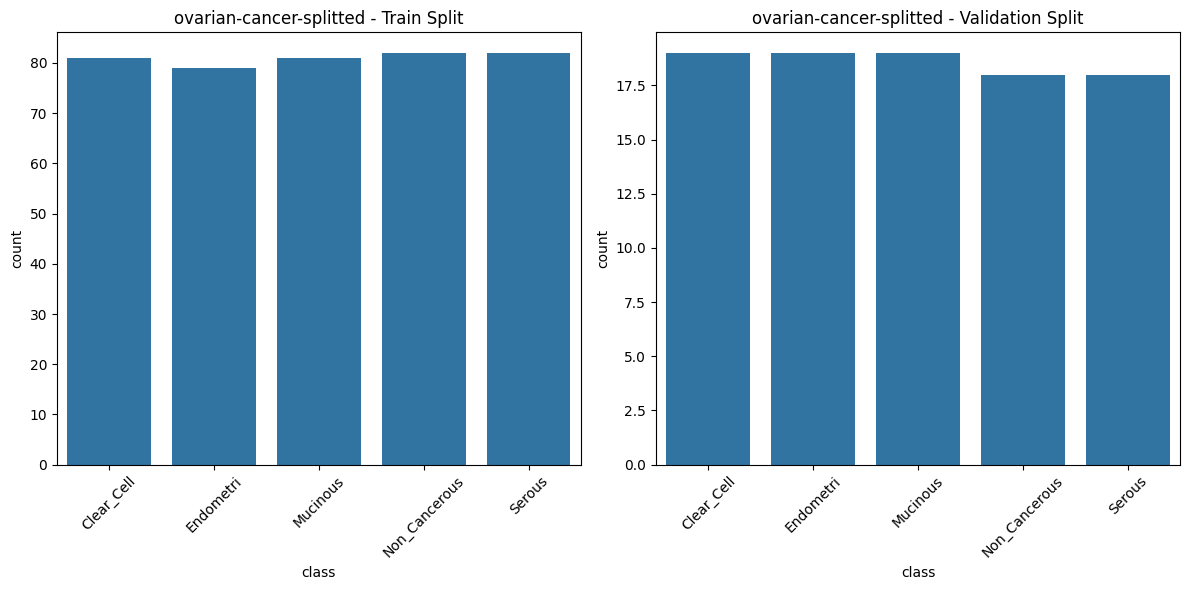

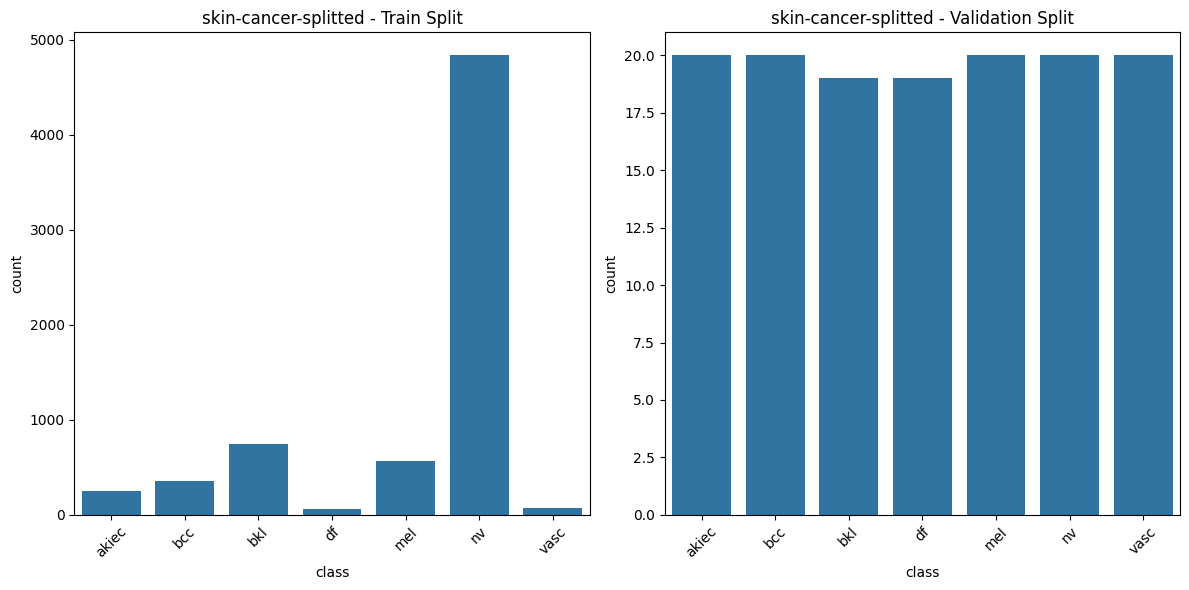

In [5]:
def plot_distribution(data: pd.DataFrame, dataset_name: str):
    plt.figure(figsize=(12, 6))
    
    # Create subplot for train split
    plt.subplot(1, 2, 1)
    train_data = data[(data['dataset'] == dataset_name) & (data['split'] == 'train')]
    sns.barplot(data=train_data, x='class', y='count')
    plt.title(f'{dataset_name} - Train Split')
    plt.xticks(rotation=45)
    
    # Create subplot for validation split
    plt.subplot(1, 2, 2)
    val_data = data[(data['dataset'] == dataset_name) & ((data['split'] == 'val') | (data['split'] == 'test'))]
    sns.barplot(data=val_data, x='class', y='count')
    plt.title(f'{dataset_name} - Validation Split')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    return plt.gcf()

# Generate plots for each dataset
for dataset in df['dataset'].unique():
    fig = plot_distribution(df, dataset)
    plt.show()

## Export Results
Save the generated tables and plots for documentation.

In [8]:
# Create output directory
output_dir = Path('analysis_results')
output_dir.mkdir(exist_ok=True)

# Save distribution table
distribution_table.to_csv(output_dir / 'class_distribution.csv')

# Save plots for each dataset
for dataset in df['dataset'].unique():
    fig = plot_distribution(df, dataset)
    # fig.savefig(output_dir / f'{dataset}_distribution.png')
    plt.close()

print("Analysis results saved to 'analysis_results' directory")

Analysis results saved to 'analysis_results' directory
